baseado em: 
>TEMPELAARS, S. **Signal processing, speech, and music**. Lisse [Netherlands]; Exton, PA: Swets & Zeitlinger Publishers, 1996. 
<br/>

# lembrando: para executar os códigos, percorra as células abaixo com as setas do teclado e aperte **Shift+Enter** a cada bloco de código, sequencialmente

obs: na primeira vez vai demorar um pouco mais porque o notebook precisa ser ativado no servidor do Google. Caso fique inativo muito tempo, o servidor é desconectado e então vocês precisará executar novamente as células abaixo de maneira sequencial.



<br/>
<br/>

Na seção 4.3 (p. 118) do seu livro, Tempelaars explica a Transformada de Fourier a partir de um exemplo simples, em que procura-se recompor uma dada função periódica a partir da soma de 5 componentes senoidais.

Neste notebook vamos percorrer o mesmo percurso realizado por Tempelaars, buscando ilustrar os princípios e métodos matemáticos que servem de base para a **Transformada de Fourier**

#### 1. preâmbulo: 

Primeiro, vamos importar as bibliotecas abaixo.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sympy as sy
import numpy as np
import IPython.display as ipd

### 2. Princípio geral

De maneira resumida, a *Tranformada de Fourier* é um método matemático pelo qual pode-se <mark>aproximar uma função periódica dada $f(x)$ a partir da soma de componentes senoidais</mark>. Como esses componentes senoidais têm parâmetros de frequência, amplitude e fase conhecidos, torna-se possível decompor sinais complexos em componentes simples com parâmetros definidos (e que podem ser utilizados em contextos diversos como análise, ressíntese e cálculo de descritores).

Tempelaars (1996, p.118) ilusta isso a partir da figura abaixo, em que uma dada função (forma de onda na parte superior) é aproximada, a partir de cinco funções senoidais que, somadas, resultam em uma função com contorno bastante próximo àquele do sinal original (forma de onda na parte inferior).

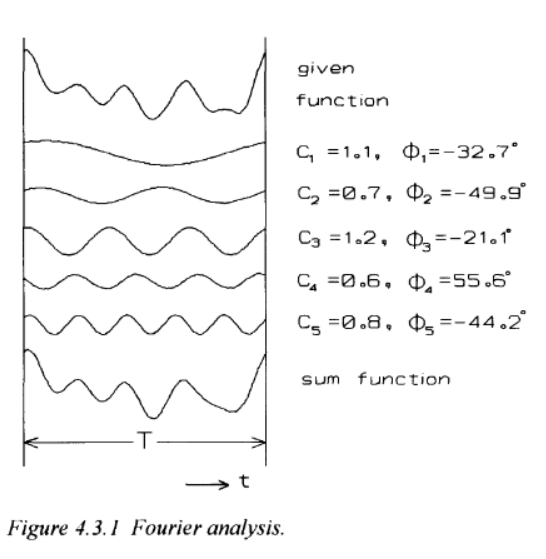

(TEMPELAARS, 1996, p.118)

> A teoria de Fourier diz que a diferença entre uma *dada função* e a *soma de funções* [senoidais] pode ser reduzida colocando-se mais funções seno em jogo. Vamos escrever as regras de função das cinco funções seno, usando o fato de que a duração total da função dada é igual a $T$. Como de costume, a frequência $f$ corresponde a $T$ via $f = 1/T$. (TEMPELAARS, 1996, p.118, [t.n.])

## 3. Modelização do processo em Python

Para conseguirmos gerar funções senoidais como aquelas da figura acima (e, em seguida, percorrer passo a passo o processo da Transformada de Fourier), utilizaremos duas fórmulas que são equivalentes e que nos ajudarão a criar uma *Série de Fourier*: série que representa um conjunto de funções trigonométricas senoidais cujas respectivas frequências são multiplicadas por inteiros consecutivos a partir de 1 (como, no exemplo acima, as cinco funções senoidais utilizadas para construir a função de soma).


A primeira fórmula descreve a função senoidal como uma senoide de amplitude $C_n$ e fase $\phi_n$ a partir da seguinte fórmula:

$C_n \cdot sin(2 \pi n f t + ϕ_n)$  

o múltiplo $n f$, na fórmula acima, descreve o número de ciclos ($n$) que a função comportará no período $T$ (já que $f = 1/T$).


Já a segunda fórmula, importante para compreendermos alguns processos envolvidos na *Transformada de Fourier*, aproveita-se do fato de que uma função senoidal com fase pode ser representada a partir da soma de um seno e um cosseno simples[¹]. Isso permite descrever a função senoidal a partir da soma de um seno e um cosseno com coeficientes de amplitude próprios:

$a_n \cdot cos(2π n f t)+ b_n sin(2πnft)$ 

sendo que a relação entre $C_n$, $\phi_n$, $a_n$ e $b_n$ se dá pelas fórmulas:

$a_n = C_n cos \phi_n$

$b_n = -C_n sin \phi_n$

$C_n = \sqrt{a_n^2 + b_n^2}$

$tan ~\phi_n = -\frac{b_n}{a_n} ~~$  ou $~~ \phi_n = arctan - \frac{b_n}{a_n}$

[¹]: <small>Para compreender melhor essa equivalência ver pags. 53 e 54 do livro de Tempelaars (em que isso é ilustrado a partir da soma de dois vetores perpendiculares) ou vídeos como esse https://www.youtube.com/watch?v=V1iK7X4iGZU.</small>

Primeiramente, vamos definir algumas funções auxiliares para converter graus para radianos e para permitir a conversão dos coeficientes polares/harmônicos $C$ e $phi$, da primeira fórmula, para coeficientes cartesianos/retangulares $a$ e $b$, da segunda fórmula.

In [2]:
## função auxiliar para conversão de graus (0-360) para radianos (0 - 2pi)
def toRad(grau):
  return ((grau%360)/180)*np.pi

# C, phi => a, b / conversão de coordenadas polares para coordenadas retangulares
def poltocar(Cphi):
  C = Cphi[0]
  phi = Cphi[1]
  return C * np.cos(phi), -1 * C * np.sin(phi)

# a, b => C, phi / conversão de coordenadas retangulares para coordenadas polares
def cartopol(ab):
  a = ab[0]
  b = ab[1]
  return np.sqrt(a*a + b*b), np.arctan(b/a)

As cinco funções senoidais na figura 4.3.1, acima, podem ser descritas tanto pela primeira fórmula (funções senoidais descritas com amplitude $C_n$ e fase $\phi_n$) ou pela segunda fórmula (cossenos com coeficiente $a_n$ somados a senos com coeficiente $b_n$). 

Para usar isso na prática, vamos escrever os valores de $C$ e $phi$ em uma lista `c_phi` e calcular os valores de $a$ e $b$ em uma segunda lista `ab`.

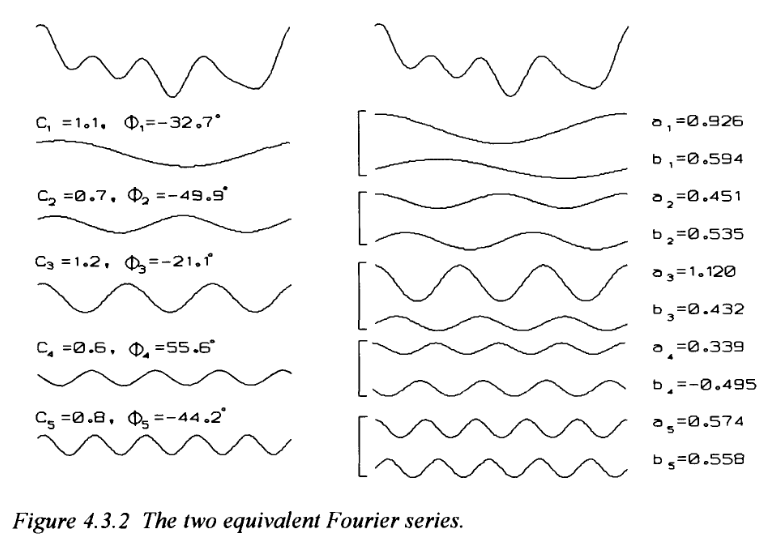

(TEMPELAARS, 1996, p.120)

In [3]:
## lista com os valores de C e phi definidos acima
c_phi = [
    [1.1,toRad(-32.7)],
    [0.7,toRad(-49.9)],
    [1.2,toRad(-21.1)],
    [0.6,toRad(55.6)],
    [0.8,toRad(-44.2)]
]

## lista correspondente de coeficientes cartesianos/retangulares (pares real/imaginário), calculada a partir da lista anterior
ab = []

for polar in c_phi:
  a,b = poltocar(polar)
  ab.append([a,b])

print("valores de C/phi:", c_phi)
print("valores de a/b:",ab)


valores de C/phi: [[1.1, 5.7124626417774405], [0.7, 5.412266010434417], [1.2, 5.9149208350087825], [0.6, 0.9704030641088471], [0.8, 5.511749777798093]]
valores de a/b: [[0.9256618601398368, 0.5942643525254209], [0.4508865408329709, 0.5354449806429019], [1.1195442417905868, 0.4319961697440619], [0.33898020205496276, -0.495068098966977], [0.5735284861203861, 0.5577320822836518]]


## 4. Definição das funções senoidais utilizado Python

Para demonstrar a *Transformada de Fourier* criaremos funções em Python que geram ondas senoidais em um período de $W$ samples. As funções serão geradas por ambos os métodos acima, e poderão ser controladas via amplitude ($C$) e fase ($\phi$) ou via coeficientes ($a$ e $b$).

Para isso, iremos utilizar a biblioteca *SymPy*, que permite trabalhar com matemática simbólica (dito de maneira simples: permite escever e plotar funções matemáticas com expressões e símbolos matemáticos como aqueles que utilizamos para escrever as fórmulas acima).

### 4.1 função em forma polar: $C \cdot cos(2 \pi n f t + ϕ)$  

In [4]:
##definição da função acima utilizando o sympy
c, phi, pi, n, f = sy.symbols('C phi pi n f', real = True, constant = True) ## definição de constantes
t = sy.symbols('t', real = True, positive=True)                             ## definição da variável t
Y = c * sy.cos(2*pi*n*f*t + phi)                                            ## definição da função (f(t))
Y

C*cos(2*f*n*pi*t + phi)

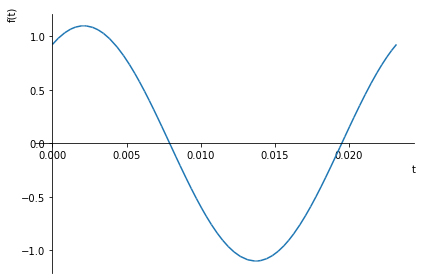

In [5]:
##plotando um período

wsamples = 1024                  ## numero de amostras em um periodo da onda
sr = 44100                       ## taxa de amostragem

pi=sy.pi                         ## valor de pi
f=sr/wsamples                    ## f (ou 1/T)
c,phi = c_phi[0]                 ## valores de C e phi, definidos acima a partir do exemplo de Tempelaars
n=1                              ## múltiplo de f (ou de 1/T)


Y1 = c * sy.cos(2*pi*n*f*t + phi) ## função

#plot
sy.plot(Y1, (t,0,wsamples/sr))

### 4.2 função em forma retangular/cartesiana: $a_n \cdot cos(2π n f t)+ b_n sin(2πnft)$ 

In [6]:
##definição da função acima utilizando o sympy
a, b, pi, n, f = sy.symbols('a b pi n f', real = True, constant = True) ## definição de constantes a, b, pi, n, e f
t = sy.symbols('t', real = True, positive=True)                         ## definição de variável t
Y = a * sy.cos(2*pi*n*f*t) + b * sy.sin(2*pi*n*f*t)                     ## definição da função
Y                                                                       ## fórmula 

a*cos(2*f*n*pi*t) + b*sin(2*f*n*pi*t)

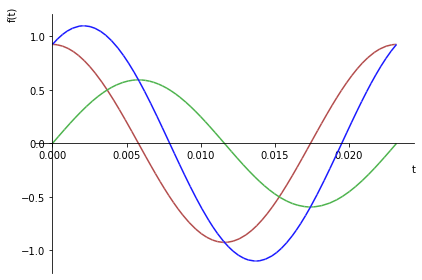

In [7]:
##plotando um período

wsamples = 1024                                                        ## numero de amostras em um periodo da onda
sr = 44100                                                             ## taxa de amostragem

a,b = ab[0]                                                            ## valores de a e b, calculados anteriormente
pi=sy.pi                                                               ## valor de pi
f=sr/wsamples                                                          ## f (ou 1/T)
n=1                                                                    ## múltiplo de f (ou de 1/T)
A1 = a * sy.cos(2*pi*n*f*t)                                             ## componente cosseno
B1 = b * sy.sin(2*pi*n*f*t)                                             ## componente seno
Y1 = A1 + B1                                                              ## definição de y ou f(t)
# plot vermelho: componente cosseno A_1
p1 = sy.plot(A1,(t,0,wsamples/sr),show=False,line_color=(0.7,0.3,0.3)) 
# plot verde: componente seno B_1
p2 = sy.plot(B1,(t,0,wsamples/sr),show=False,line_color=(0.3,0.7,0.3)) 
# plot azul: soma Y_1
p3 = sy.plot(Y1,(t,0,wsamples/sr),show=False,line_color=(0.1,0.1,1))   
p1.append(p2[0])
p1.append(p3[0])

p1.show()              ## exibe plot

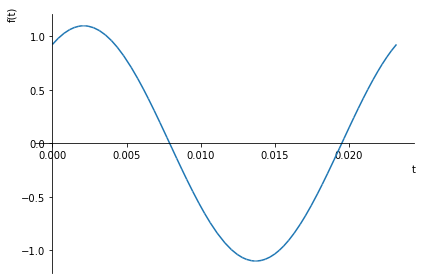

In [8]:
##plot apenas da função y
sy.plot(Y1,(t,0,wsamples/sr))

## 5. Série de Fourier

Dito de maneira simples, a *Série de Fourier* é uma somatória de funções trigonométricas simples que permite representar funções periódicas complexas.

A fórmula quadrática da série de Fourier é:

$$ \frac{{a}_{0}}{2} + \sum_{n=1}^{\infty} {a}_{n}\cos{(2 \pi n f t)} + {b}_{n}\sin{(2 \pi n f t)} $$

In [9]:
## Série de Fourier, utilizando sympy

pi, n, f = sy.symbols('pi n f', real = True, constant = True)
t = sy.symbols('t', real = True, positive=True)
a = sy.IndexedBase('a')
b = sy.IndexedBase('b')

fourierseries = a[0]/2 + sy.Sum(a[n] * sy.cos(2*pi*n*f*t) + b[n] * sy.sin(2*pi*n*f*t), (n, 1, sy.oo))
fourierseries ## OBS: o sympy não coloca os elementos da expressão matemática na mesma ordem que utilizamos


a[0]/2 + Sum(sin(2*f*n*pi*t)*b[n] + cos(2*f*n*pi*t)*a[n], (n, 1, oo))

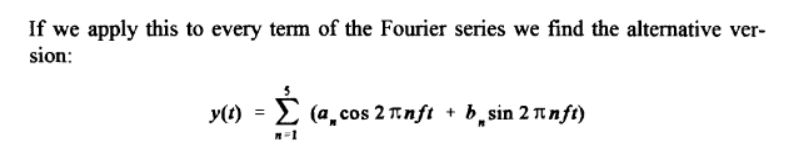

(TEMPELAARS, 1996, p.120)

Utilizando a fórmula da *Série de Fourier* acima, podemos construir a somatória das cinco funções do exemplo de Tempelaars <small>(**OBS**: Por ora, estamos considerando $\frac{a_0}{2} = 0$ [veremos mais sobre isso adiante]).</small>

In [10]:
pi, n, f, m = sy.symbols('pi n f m', real = True, constant = True)              ## constantes pi, n, f e m
t = sy.symbols('t', real = True, positive=True)                                 ## variável t
a = sy.IndexedBase('a')                                                         ## coeficientes a_1, a_2, etc..
b = sy.IndexedBase('b')                                                         ## coeficientes b_1, b_2, etc..

Y = sy.Sum(a[n] * sy.cos(2*pi*n*f*t) + b[n] * sy.sin(2*pi*n*f*t), (n, 1, m))    ## somatória de funções 
Y = Y.subs(m,5)                                                                 ## especificação que n deve ir de 1 a 5 (pois estamos trabalhando com 5 funções)
Y                                                                               ## função

Sum(sin(2*f*n*pi*t)*b[n] + cos(2*f*n*pi*t)*a[n], (n, 1, 5))

Para plotar essa soma, abaixo substituiremos as variáveis/contantes/coeficientes por valores numéricos. 

Em seguida, transformaremos a função simbólica, criada com a biblioteca *SymPy*, em uma função computacional em Python e *NumPy* <small>(biblioteca voltada a cálculos de álgebra lineas com vetores e matrizes)</small> que permitirá inserir os valores de $t$ como um vetor/*array*.

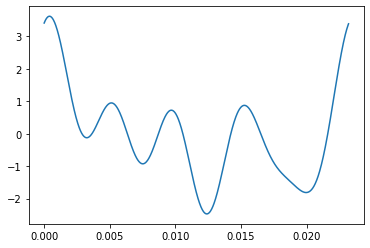

In [11]:
wsamples = 1024                                                         ## numero de amostras em um periodo (T) da onda
srate = 44100                                                           ## taxa de amostragem
fval=srate/wsamples                                                     ## cálculo do valor de f (ou 1/T)
t_vals = np.arange(0,wsamples/srate,1/srate)                            ## sére de valores para t

Y = Y.subs(pi,np.pi).doit()                                             ## substituição da variável pi pelo valor numérico correspondente
Y = Y.subs(f,fval).doit()                                               ## substituição da variável f pelo valor calculado acima para fval

for i in np.arange(1,6):                                                ## substituição de a_1, a_2, ..., a_5 e b_1, b_2, ..., b_5 pelos valores calculados anterioremente (lista ab) 
  Y = Y.subs([(a[i], ab[i-1][0]), (b[i], ab[i-1][1])]).doit()     

Ylambda = sy.lambdify(t, Y, 'numpy')                                    ## transformação da função simbólica Y em uma função lambda Ylambda que aceita vetores do numpy

Y_vals = Ylambda(t_vals)                                                ## cálculo a partir dos valores de t
plt.plot(t_vals,Y_vals)                                                 ## plot


Abaixo, plotamos cada uma das funções 5 senoidais e a soma delas, abaixo.

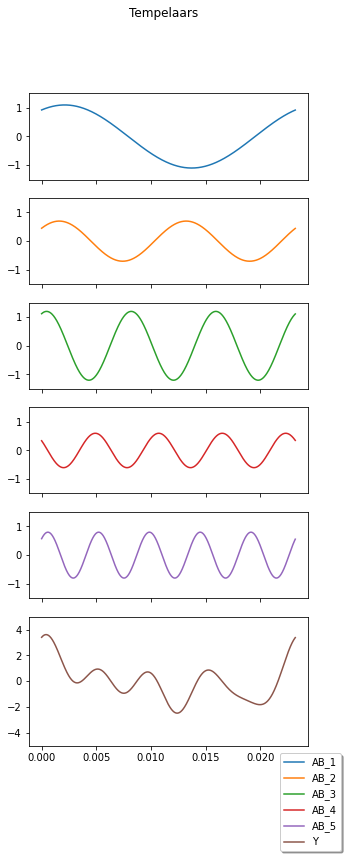

In [12]:
colors = plt.rcParams["axes.prop_cycle"]()                              ## variável para guardar cores                      

AB = a * sy.cos(2*pi*n*f*t) + b * sy.sin(2*pi*n*f*t)                    ## função senoidal em formato cartesiano/retangular
AB = AB.subs(pi,np.pi).doit()                                           ## substituição da variável pi pelo valor numérico correspondente
AB = AB.subs(f,fval).doit()                                             ## substituição da variável f pelo valor calculado acima para fval

ABcomponents = []                                                       ## lista onde guardaremos cada componente senoidal

ABlambda = sy.lambdify([n,a,b,t],AB,'numpy')                            ## função Python/Numpy para gerar dados de cada componente senoidal

for i in np.arange(1,6):                                                
  component_vals= ABlambda(i,ab[i-1][0],ab[i-1][1],t_vals)
  ABcomponents.append(component_vals)

fig, axs = plt.subplots(6, 
                        figsize=(5, 12),
                        sharex=True,
                        gridspec_kw={'height_ratios': [2,2,2,2,2,3]})

fig.suptitle('Tempelaars')

for i in range(5):
  axs[i].plot(t_vals,ABcomponents[i], color=next(colors)["color"], label=f'AB_{i+1}')
  axs[i].set_ylim([-1.5,1.5])
  

axs[5].plot(t_vals, Y_vals, color=next(colors)["color"], label="Y")
axs[5].set_ylim([-5,5])

fig.legend(shadow=True, fancybox=True,loc="lower right")
plt.show()


## 6. O termo constante

> A somatória de funções seno sempre leva a uma função de soma que é *simétrica* em relação à linha zero (em outras palavras, o valor médio é zero). Isso poderia indicar a limitação da aplicabilidade da série de Fourier a funçõe simétricas, mas existe também uma representação em Fourier para funções assimétricas, porque qualquer função assimétrica pode ser escrita como a soma de uma função simétrica $S$ e um termo constante $D$.  (TEMPELAARS, 1996, p.121, [t.n.])


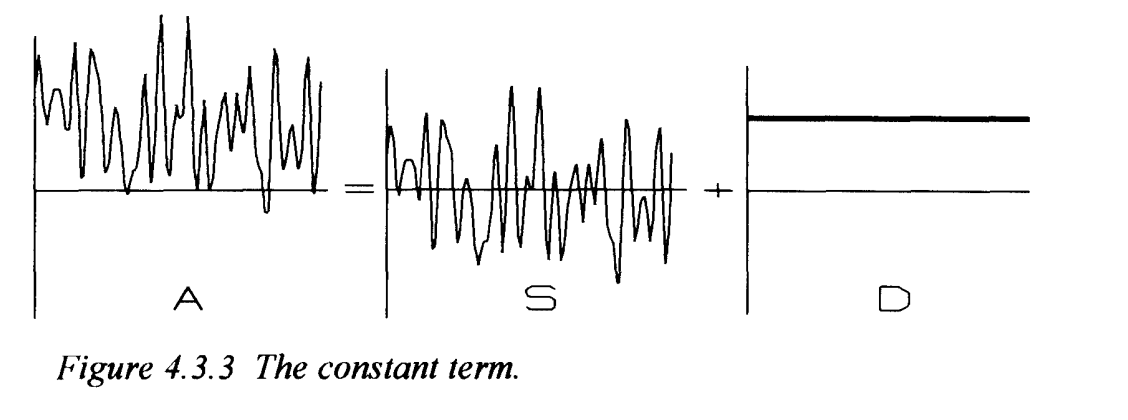

(TEMPELAARS, 1996, p.121)

O que podemos demonstrar somando nossa função anterior com uma função constante:

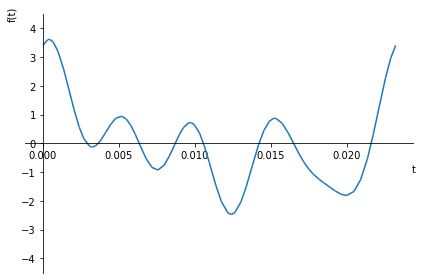

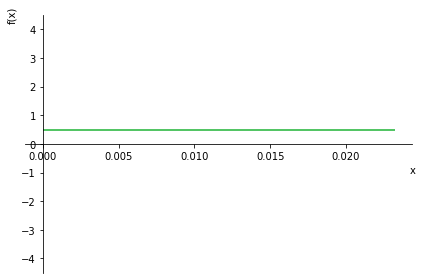

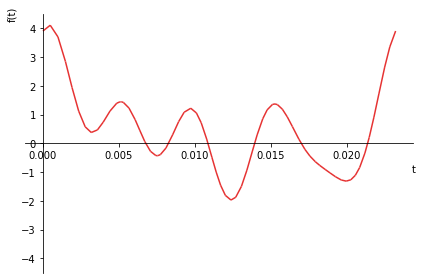

In [13]:
DC = 0.5

p1 = sy.plot(Y,(t,0,wsamples/srate),ylim=[-4.5,4.5], show=False)
p2 = sy.plot(DC, (t,0,wsamples/srate),line_color=(0.1,0.7,0.2),ylim=[-4.5,4.5],show=False)

Y_DC = Y+DC


p3 = sy.plot(Y_DC,(t,0,wsamples/srate),line_color=(0.9,0.2,0.2),ylim=[-4.5,4.5], show=False)
p1.show() ## função Y, criada anteriormente [azul]
p2.show() ## função DC, f(t) = 0.5 [verde]
p3.show() ## Y + DC [vermelho]


Por razões práticas (a ver adiante), este termo contante é designado como $ \frac{1}{2}a_0$, resultando na fórmula que vimos anteriormente:

$$ y(t) = \frac{{a}_{0}}{2} + \sum_{n=1}^{\infty} {a}_{n}\cos{(2 \pi n f t)} + {b}_{n}\sin{(2 \pi n f t)} $$

## 7. Determinando os coeficientes de Fourier

Para determinar os coeficientes da *Série de Fourier* que nos retorna uma função de soma semelhante àquela analisada, precisamos utilizar a fórmula cartesiana/retangular das funções senoidais (i.e., com os coeficientes $a_n$ e $b_n$).

> Comecemos determinando o termo constante $a_0$. Ele é, na realidade, fácil de ser descoberto. Como nós sabemos que $\frac{1}{2}a_0$ é a diferença entre o valor médio da função e 0, nós apenas precisamos calcular o esse valor médio. (...) Para uma função discreta no tempo $y(k)$ (com $N$ amostras nesse intervalo de tempo) isso é: (TEMPELAARS, 1996, p.122, [t.n.])

$$ \textrm{valor médio} = \frac{1}{N} \sum_{k=0}^{N-1} y(k) = \frac{1}{2}a_0$$

Transformando a função `Y_DC` acima em uma função python e aplicandos os respectivos valores de $t$, isso pode ser facilmente calculado, de maneira a obter o resultado da equação:

$$ a_0 = \frac{2}{N} \sum_{k=0}^{N-1} $$

In [14]:
Y_DClambda = sy.lambdify([t],Y_DC,'numpy')         ## transformando a expressão numérica da função Y_DC em uma função python
Y_DCvals = Y_DClambda(t_vals)                      ## vetor com o resultado da função Y_DClambda para cada valor de t_vals
half_a0 = np.mean(Y_DCvals)                        ## valor de 1/2 a_0
a0 = 2*half_a0                                     ## valor de a_0
a0                                                 ## a_0 (obs: valores como 0.0000000000000024 a mais devem-se a erros de quantização)

1.0000000000000024

> O cálculo dos demais coeficientes é um pouco mais complicado, mas ainda assim comparável com aquele de $a_0$. <mark>O princípio é o seguinte: para a determinação de $a_n$ (e, respectivamente, de $b_n$) a função é multiplicada por $cos (2 \pi n f t)$ (e, respectivamente, por $sin (2 \pi n f t)$), e após isso o valor médio desse produto é calculado.</mark> (TEMPELAARS, 1996, p.122, [t.n.])

Tempelaars explica isso demonstrando o cálculo do coeficiente $a_2$ e a seguinte legenda:

  - $Y$ => uma função dada $y(t)$

  - $H_n$ => os componentes senoidais, em forma harmônica, $C_n cos(2 \pi n f t + \phi_n)$

  - $A_n$ => o termo cosseno $a_n cos 2\pi n f t$ de cada componente

  - $B_n$ => o termo seno $b_n sin 2\pi n f t$ de cada componente

  - $K_2$ => <mark>a função $cos 2 \pi 2 f t$ pela qual nós mutiplicaremos os componentes</mark> 

Ao multiplicar a função $Y$ por $K_2$, estamos também multiplicando cada um dos componentes ($A_n$ + $B_n$) por $K_2$, o que é expandido abaixo:

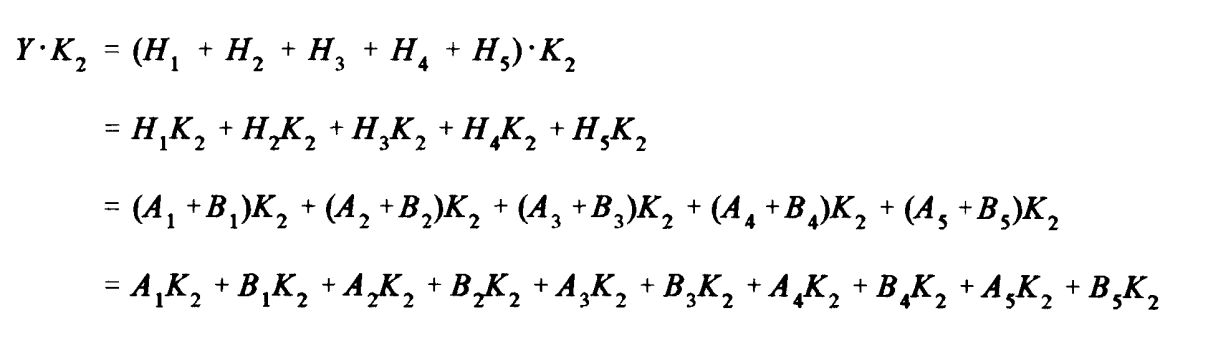 
(TEMPELAARS, 1996, p.123)

Vamos fazer isso em Python, utilizando as funções que definimos anteriormente. De maneira a facilitar a plotagem (equivalente àquela realizada na figura 4.3.4 do livro de Tempelaars, transformaremos as funções $Y$, $A_n$, $B_n$ e $K_2$ em funções lambda/Python, que nos retornarão vetores que poderão ser facilmente plotados com cada termo, o resultado da multiplição ($Y \cdot K_2$; $A_n \cdot K_2$ e $B_n \cdot K_2$) e o valor médio de cada um desses termos.

Além de plotar nos gráficos à direita a multiplicação de cada termo, plotaremos também o valor médio dessa multiplicação.

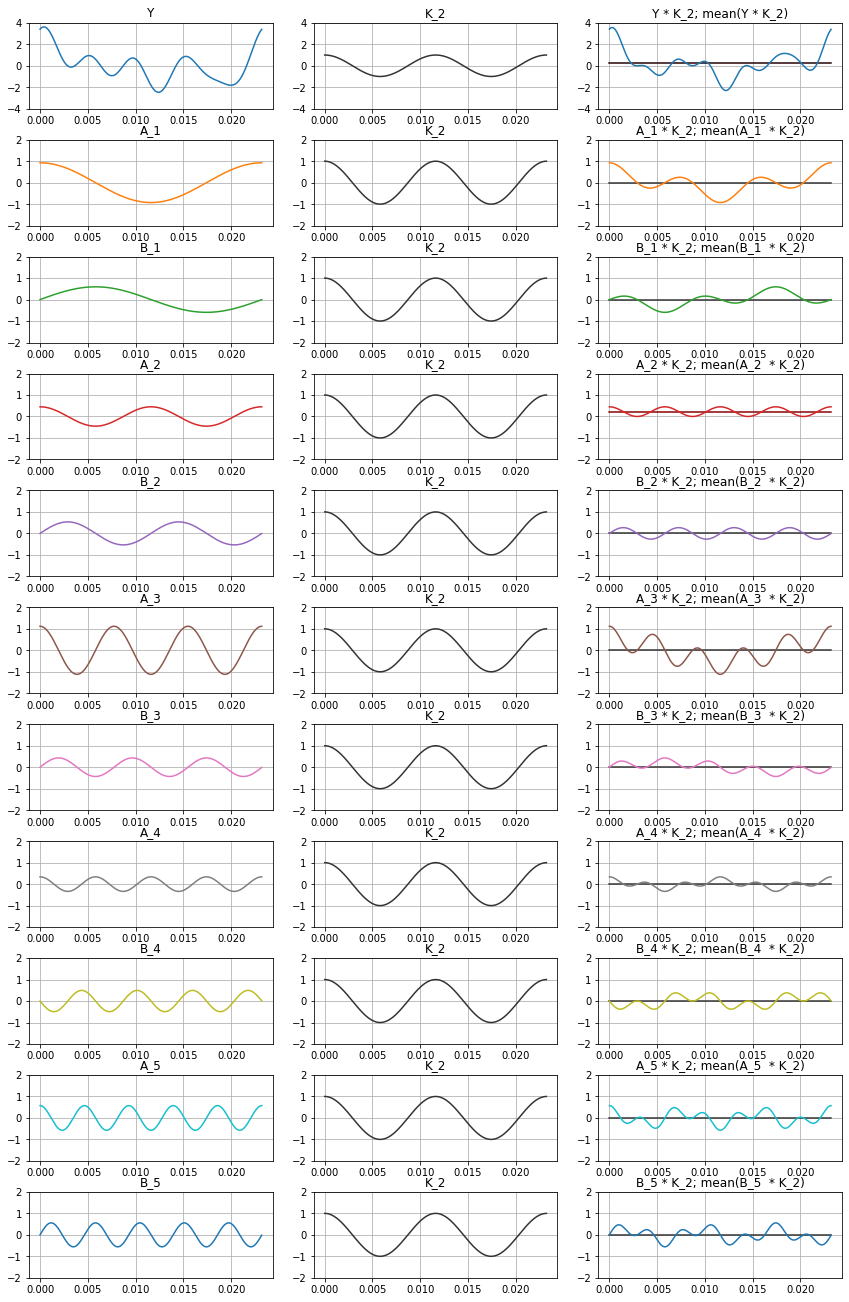

In [37]:
colors = plt.rcParams["axes.prop_cycle"]()                                      ## variável para guardar cores                      
wsamples = 1024                                                                 ## numero de amostras em um periodo (T) da onda
srate = 44100                                                                   ## taxa de amostragem
fval=srate/wsamples                                                             ## cálculo do valor de f (ou 1/T)
t_vals = np.arange(0,wsamples/srate,1/srate)                                    ## sére de valores para t

pi, n, f, m = sy.symbols('pi n f m', real = True, constant = True)              ## constantes pi, n, f e m
t = sy.symbols('t', real = True, positive=True)                                 ## variável t
a = sy.IndexedBase('a')                                                         ## coeficientes a_1, a_2, etc..
b = sy.IndexedBase('b')                                                         ## coeficientes b_1, b_2, etc..

Y = sy.Sum(a[n] * sy.cos(2*pi*n*f*t) + b[n] * sy.sin(2*pi*n*f*t), (n, 1, m))    ## somatória de funções A_n+B_n
Y = Y.subs(m,5)                                                                 ## restringe somatória a 5 funções

Y = Y.subs(pi,np.pi).doit()                                                     ## substituição da variável pi pelo valor numérico correspondente
Y = Y.subs(f,fval).doit()                                                       ## substituição da variável f pelo valor calculado acima para fval

for i in np.arange(1,6):                                                        ## substituição de a_1, a_2, ..., a_5 e b_1, b_2, ..., b_5 pelos valores calculados anterioremente (lista ab) 
  Y = Y.subs([(a[i], ab[i-1][0]), (b[i], ab[i-1][1])]).doit()     

An = a * sy.cos(2*pi*n*f*t)                                                     ## fórmula de A_n
Bn = b * sy.sin(2*pi*n*f*t)                                                     ## fórmula de B_n
ABn = An + Bn                                                                   ## fórmula de A_n+B_n (igual a H_n)

An = An.subs(pi,np.pi).doit()                                                   ## substituição da variável pi pelo valor numérico correspondente
Bn = Bn.subs(pi,np.pi).doit()
ABn = ABn.subs(pi,np.pi).doit() 

An = An.subs(f,fval).doit()                                                     ## substituição da variável f pelo valor calculado acima para fval
Bn = Bn.subs(f,fval).doit()
ABn = ABn.subs(f,fval).doit()                                       

An_vals = [ ]                                                                   ## array onde guardaremos os vetores dos valores de cada função A_n
Bn_vals = [ ]                                                                   ## array onde guardaremos os vetores dos valores de cada função B_n
ABn_vals = [ ]                                                                  ## array onde guardaremos os vetores dos valores de cada função AB_n
K2_vals = [ ]                                                                   ## array onde guardaremos os vetores dos valores de cada função K_2 (igual a A_2)

Ylambda = sy.lambdify(t,Y, 'numpy')  

Anlambda = sy.lambdify([n,a,t],An, 'numpy')  
Bnlambda = sy.lambdify([n,b,t],Bn, 'numpy')  
ABnlambda = sy.lambdify([n,a,b,t],ABn, 'numpy')     

Y_vals = Ylambda(t_vals)

for i in np.arange(1,6):    
  a_i = ab[i-1][0]
  b_i = ab[i-1][1]
  Acomp = Anlambda(i,a_i,t_vals)
  Bcomp = Bnlambda(i,b_i,t_vals)
  ABcomp = ABnlambda(i,a_i,b_i,t_vals)
  An_vals.append(Acomp)
  Bn_vals.append(Bcomp)
  ABn_vals.append(ABcomp)

K2_vals = Anlambda(2,1,t_vals)

fig, axs = plt.subplots(11,3, 
                        figsize=(12, 18),
                        )

fig.tight_layout(pad=1.0)

thiscolor = next(colors)["color"]
axs[0,0].title.set_text('Y')
axs[0,0].plot(t_vals, Y_vals, color=thiscolor, label='Y')
axs[0,0].set_ylim([-4,4])
axs[0,0].grid()
axs[0,1].title.set_text('K_2')
axs[0,1].plot(t_vals, K2_vals, color='#333333', label='K_2')
axs[0,1].set_ylim([-4,4])
axs[0,1].grid()
ymean = np.full(len(t_vals),np.mean(Y_vals*K2_vals))
axs[0,2].title.set_text('Y * K_2; mean(Y * K_2)')
axs[0,2].plot(t_vals, ymean, color='#220000',label='Y * K_2')
axs[0,2].plot(t_vals, Y_vals*K2_vals, color=thiscolor,  label='Y * K_2')
axs[0,2].set_ylim([-4,4])
axs[0,2].grid()

for i in range(5):    
  Acomp = An_vals[i]
  aind = i*2+1
  Bcomp = Bn_vals[i]
  bind = i*2+2
  thiscolor = next(colors)["color"]
  axs[aind,0].title.set_text(f'A_{i+1}')
  axs[aind,0].plot(t_vals, Acomp, color=thiscolor, label=f'A_{i+1}')
  axs[aind,0].set_ylim([-2,2])
  axs[aind,0].grid()
  axs[aind,1].title.set_text('K_2')
  axs[aind,1].plot(t_vals, K2_vals, color='#333333', label='K_2')
  axs[aind,1].set_ylim([-2,2])
  axs[aind,1].grid()
  ymean = np.full(len(t_vals),np.mean(Acomp*K2_vals))
  axs[aind,2].title.set_text(f'A_{i+1} * K_2; mean(A_{i+1}  * K_2)')
  if i!=1:
    meancolor = '#333333'
  else:
    meancolor = '#880000'
  axs[aind,2].plot(t_vals, ymean, color=meancolor,label=f'A_{i+1} * K_2; mean(A_{i+1}  * K_2)')
  axs[aind,2].plot(t_vals, Acomp*K2_vals, color=thiscolor)
  axs[aind,2].set_ylim([-2,2])
  axs[aind,2].grid()
  
  thiscolor = next(colors)["color"]
  axs[bind,0].title.set_text(f'B_{i+1}')
  axs[bind,0].plot(t_vals, Bcomp, color=thiscolor, label=f'B_{i+1}')
  axs[bind,0].set_ylim([-2,2])
  axs[bind,0].grid()
  axs[bind,1].title.set_text('K_2')
  axs[bind,1].plot(t_vals, K2_vals, color='#333333', label='K_2')
  axs[bind,1].set_ylim([-2,2])
  axs[bind,1].grid()
  ymean = np.full(len(t_vals),np.mean(Bcomp*K2_vals))
  axs[bind,2].title.set_text(f'B_{i+1} * K_2; mean(B_{i+1}  * K_2)')
  meancolor = '#333333'
  axs[bind,2].plot(t_vals, ymean, color=meancolor,label=f'B_{i+1} * K_2; mean(B_{i+1}  * K_2)')
  axs[bind,2].plot(t_vals, Bcomp*K2_vals, color=thiscolor)
  axs[bind,2].set_ylim([-2,2])
  axs[bind,2].grid()

plt.show()


Podemos perceber duas coisas:
  1. com exceção de $Y \cdot K_2$ e $A_2 \cdot K_2$, todas as médias (linhas constantes nos gráficos à direita) são iguais a $0$.
  2. o valor obtido pela média de $Y \cdot K_2$ e pela média de $A_2 \cdot K_2$ são iguais <small>
  
  (**OBS**: no cálculo abaixo as últimas casas decismais divergem apenas por erros de quantização relacionados à representação de números flutuantes no computador)</small>

In [30]:
print(f"média de Y*K_2: {np.mean(Y_vals*K2_vals)}")
print(f"média de A_2*K_2: {np.mean(An_vals[1]*K2_vals)}")
##OBS: as diferenças decimais devem-se a erros de quantização 

média de Y*K_2: 0.22544327041648746
média de A_2*K_2: 0.22544327041648538


Isso se deve ao fato de que, quando uma função periódica sem termo constante (sem DC, portanto simétrica em torno de $0$) é multiplicada por ela mesma, não apenas obtemos a potência das amostras uma a uma como, também, não temos mais os valores negativos que tornavam a função simétrica. Isso só ocorre com funções senoidais que tenham a mesma periodicidade e fase (o que a forma cartesiana permite calcular).


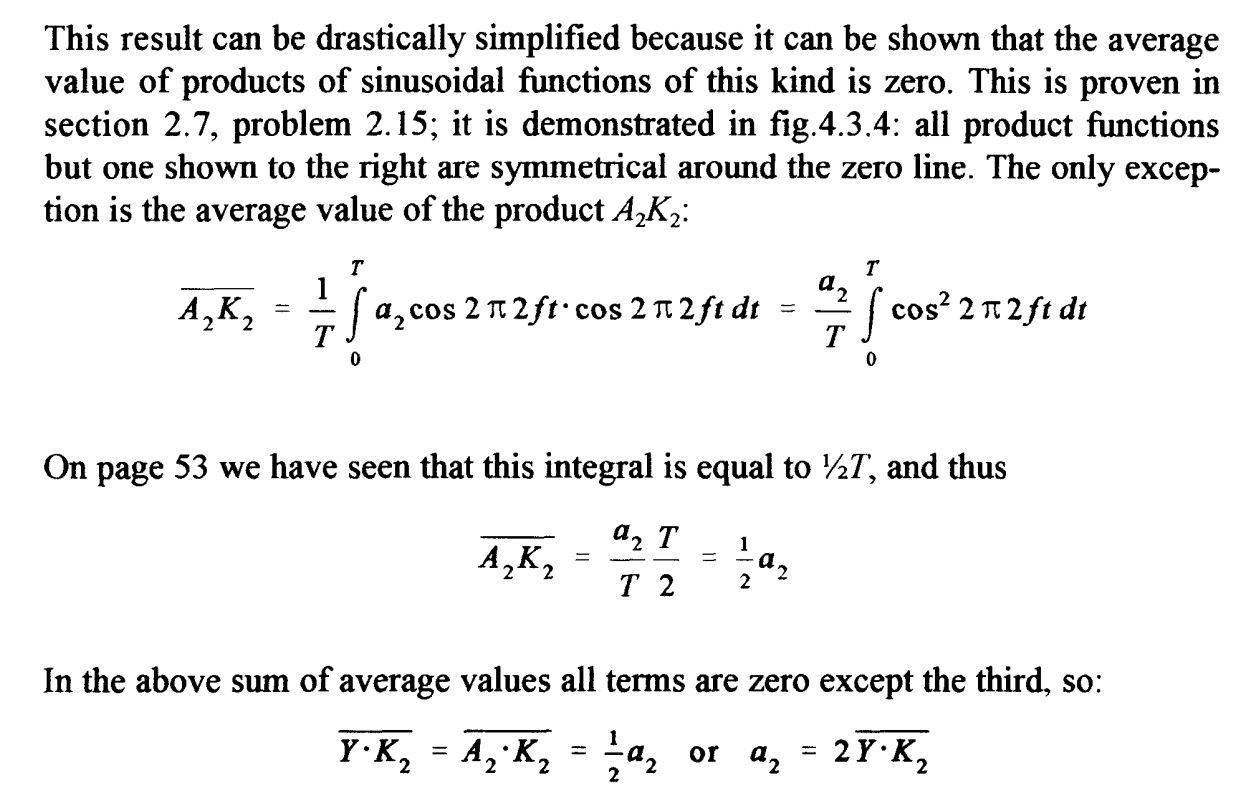

 (TEMPELAARS, 1996, p.123)

Portanto, o termo $a_2$ -- calculado como $2 (\overline{Y \cdot K_2})$, nos retornará exatamente o mesmo valor que definimos no vetor `ab` para $a_2$ (`ab[1][0]`) para montar nossa função de soma $Y$:

In [39]:
print(f'valor obtido para a2: {2 * np.mean(Y_vals*K2_vals)}')
print(f'valor de a2 definido: {ab[1][0]}')

valor obtido para a2: 0.4508865408329749
valor de a2 definido: 0.4508865408329709


Assim, para calcular os valores de a_n e b_n, basta multiplicar os valores de `Y_vals` por funções $K_n$ e $S_n$:

$K_n = cos 2 \pi \frac{n}{N}k$ para obter coeficientes $a_n$

e

$S_n = sin 2 \pi \frac{n}{N}k$ para obter coeficientes $b_n$

In [43]:
ab_fourier = [ ]

for i in np.arange(1,6):
  
  kn_vals = Anlambda(i,1,t_vals)
  sn_vals = Bnlambda(i,1,t_vals)
  thisa = 2 * np.mean(kn_vals * Y_vals)
  thisb = 2 * np.mean(sn_vals * Y_vals)
  ab_fourier.append([thisa,thisb])

print("valores calculados para [a_1,b_1],[a_2,b_2], etc: (arredondados)")
for i,val in enumerate(ab_fourier):
  i=i+1
  print(f'a_{i}: {np.round(val[0],3)} / b_{i}: {np.round(val[1],3)}')
print("valores originai para [a_1,b_1],[a_2,b_2], etc: (arredondos)")
for i,val in enumerate(ab):
  i=i+1
  print(f'a_{i}: {np.round(val[0],3)} / b_{i}: {np.round(val[1],3)}')

  

valores calculados para [a_1,b_1],[a_2,b_2], etc: (arredondados)
a_1: 0.926 / b_1: 0.594
a_2: 0.451 / b_2: 0.535
a_3: 1.12 / b_3: 0.432
a_4: 0.339 / b_4: -0.495
a_5: 0.574 / b_5: 0.558
valores originai para [a_1,b_1],[a_2,b_2], etc: (arredondos)
a_1: 0.926 / b_1: 0.594
a_2: 0.451 / b_2: 0.535
a_3: 1.12 / b_3: 0.432
a_4: 0.339 / b_4: -0.495
a_5: 0.574 / b_5: 0.558


Para calcular os valores de amplitude e fase, basta utilizar as fórmulas de conversão de coordenadas cartesianas/retangulares para coordenadas polares que definimos anteriormente:

In [45]:
print("valores calculados para [C_1,phi_1],[C_2,phi_2], etc: (arredondados)")
for i,val in enumerate(ab_fourier):
  i=i+1
  C,phi = cartopol([val[0],val[1]])
  print(f'C_{i}: {np.round(C,3)} / phi_{i}: {np.round(phi,3)}')
print("valores originai para [C_1,phi_1],[C_2,phi_2], etc: (arredondos)")
for i,val in enumerate(ab):
  i=i+1
  C,phi = cartopol([val[0],val[1]])
  print(f'C_{i}: {np.round(C,3)} / phi_{i}: {np.round(phi,3)}')

valores calculados para [C_1,phi_1],[C_2,phi_2], etc: (arredondados)
C_1: 1.1 / phi_1: 0.571
C_2: 0.7 / phi_2: 0.871
C_3: 1.2 / phi_3: 0.368
C_4: 0.6 / phi_4: -0.97
C_5: 0.8 / phi_5: 0.771
valores originai para [C_1,phi_1],[C_2,phi_2], etc: (arredondos)
C_1: 1.1 / phi_1: 0.571
C_2: 0.7 / phi_2: 0.871
C_3: 1.2 / phi_3: 0.368
C_4: 0.6 / phi_4: -0.97
C_5: 0.8 / phi_5: 0.771


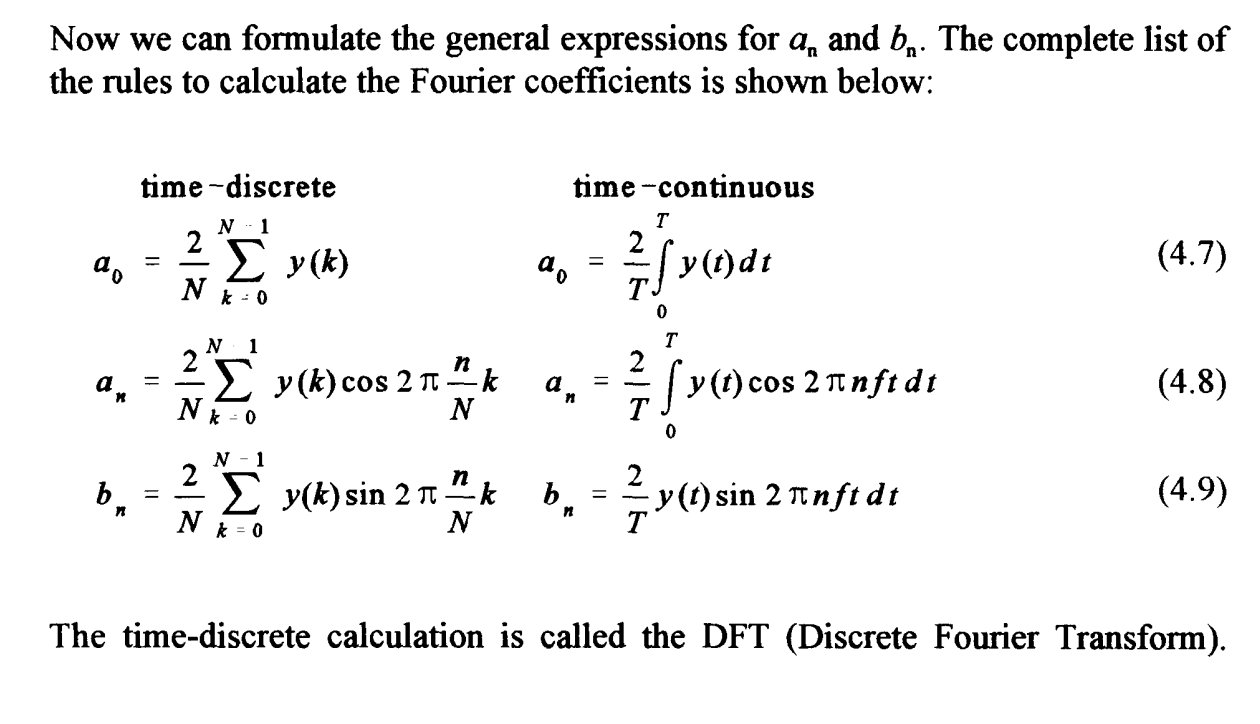

(TEMPELAARS, 1996, p.123)